In [2]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('data/train.csv')

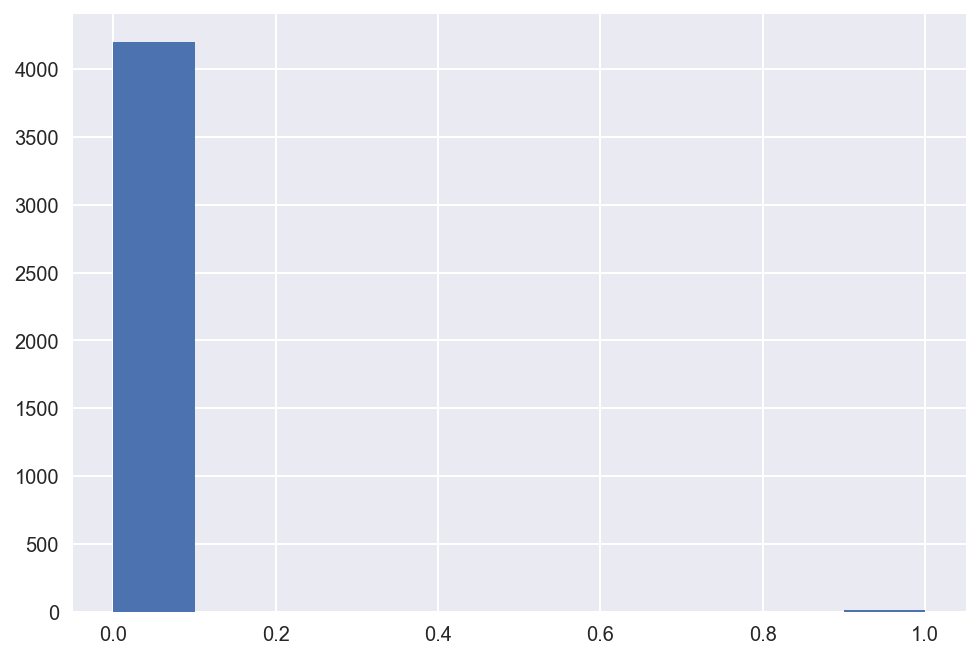

In [5]:
plt.hist(train.iloc[:,300])
plt.show()